# California Socioeconomic Relations Dataset
#### Luke Kearney, Tiger Cross, Joon-Ho Son, Theo Cohen, Jonas Scholz

***

- [1. Introduction](#intro)
    - [1.1 Dataset Background](#background)
    - [1.2 Project Structure](#structure)
- [2. Data Preparation](#data-preparation)
    - [2.1 Overview of Features](#data-features)
    - [2.2 Incomplete Data](#data-incomplete)
- [3. Exploratory data analysis](#data-analysis)
- [4. Case Study](#case-study)
- [5. Classification](#classification)
- [6. Summary](#summary)

***
## 1. Introduction<a class="anchor" id="intro"></a>
### 1.1 Dataset Background<a class="anchor" id="background"></a>


The given dataset consists of geodatabase data that combines data from the 2012-2016 American Community Survey (ACS) 5-year estimates and Topologically Integrated Geographic Encoding and Referencing (TIGER) Shapefiles. It can be found at https://www.census.gov/programs-surveys/acs/.

The ACS carry out this supplemental survey every year. More information about these surveys can be found at https://www.census.gov/programs-surveys/acs/. The 5-year estimates that comprises this data is an aggregation of 60 months of ACS data.

We began the task by getting a high level overview of the features. This notebook will explore various correlations discovered during analysis of the provided dataset, and in particular will have a focus on investigating factors affecting **educational attainment**. 

### 1.2 Project Structure<a class="anchor" id="structure"></a>

```Python
data/
data/raw/ # Raw data
data/interim/ # Interim data
data/processed/ # Processed data
imgs/ # Saved images
notebooks/
README.md
src/
```

***
## 2. Data Preparation<a class="anchor" id="data-processing"></a>
### 2.1 Overview of Features<a class="anchor" id="data-overview"></a>

We used pandas and dictionaries available in python to map the long column names for each csv into a more readable table so we could identify the different column names for each table that we could try and find a correlation between: 

In [2]:
# Standard python packages
import os
import sys
from pathlib import Path # For portable paths

# Other package imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [13]:
data_folder = Path("../data/")
raw_data_folder = data_folder / "raw" / "train"

metadata = pd.read_csv(raw_data_folder / "BG_METADATA_2016.csv")

In [16]:
def replace_columns(df):
    """
    Replace the 'short name' of each column of a given data frame with the 'long name' in the metadata file  
    
    Args:
        df: The dataframe to reformat headings on.
        
    Returns:
        The dataframe with reformatted headings.
    """
    labels = pd.Series(metadata["Full_Name"].values,index=metadata["Short_Name"]).to_dict()
    df = df.rename(columns=labels)
    return df

In [17]:
dfs = {}

path = "../data/raw/train/"
for f in os.listdir(path):
    print(f"Reformatted columns names of {f}")
    df = pd.read_csv(path+f)
    df = replace_columns(df)
    dfs[f] = df

Reformatted columns names of X12_MARITAL_STATUS_AND_HISTORY.csv
Reformatted columns names of X01_AGE_AND_SEX.csv
Reformatted columns names of X07_MIGRATION.csv
Reformatted columns names of X27_HEALTH_INSURANCE.csv
Reformatted columns names of X08_COMMUTING.csv
Reformatted columns names of X19_INCOME.csv
Reformatted columns names of BG_METADATA_2016.csv
Reformatted columns names of X22_FOOD_STAMPS.csv
Reformatted columns names of X03_HISPANIC_OR_LATINO_ORIGIN.csv
Reformatted columns names of X23_EMPLOYMENT_STATUS.csv
Reformatted columns names of X15_EDUCATIONAL_ATTAINMENT.csv
Reformatted columns names of X11_HOUSEHOLD_FAMILY_SUBFAMILIES.csv
Reformatted columns names of X16_LANGUAGE_SPOKEN_AT_HOME.csv
Reformatted columns names of X21_VETERAN_STATUS.csv
Reformatted columns names of X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv
Reformatted columns names of X14_SCHOOL_ENROLLMENT.csv
Reformatted columns names of X00_COUNTS.csv
Reformatted columns names of X99_IMPUTATION.csv
Reformatted columns nam

We identified our overall response variable `y` as The *population over the age of 25 that have attained a bachelors degree or higher*, This is from the following table:

In [18]:
dfs['X15_EDUCATIONAL_ATTAINMENT.csv'][:10]

,Unnamed: 0,GEOID,SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Total: Population 25 years and over -- (Estimate),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Total: Population 25 years and over -- (Margin of Error),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: Population 25 years and over -- (Estimate),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: Population 25 years and over -- (Margin of Error),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: No schooling completed: Population 25 years and over -- (Estimate),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: No schooling completed: Population 25 years and over -- (Margin of Error),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: Nursery to 4th grade: Population 25 years and over -- (Estimate),SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Male: Nursery to 4th grade: Population 25 years and over -- (Margin of Error),...,FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Science and Engineering: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Science and Engineering Related Fields: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Science and Engineering Related Fields: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Business: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Business: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Education: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate),FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Education: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error),"FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Arts, Humanities and Other: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate)","FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR THE POPULATION 25 YEARS AND OVER (HISPANIC OR LATINO): Arts, Humanities and Other: HISPANIC OR LATINO POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Margin of Error)",OBJECTID
0,0,15000US060014001001,2478,125,1274,109,0,12,9,13,...,24,0,12,0,12,0,12,0,12,3
1,1,15000US060014002001,843,79,427,54,0,12,0,12,...,22,7,11,6,9,0,12,26,22,4
2,2,15000US060014002002,716,82,313,52,0,12,0,12,...,16,0,12,0,12,0,12,13,19,5
3,3,15000US060014003001,973,329,501,189,0,12,0,12,...,21,0,12,0,12,0,12,13,25,6
4,4,15000US060014003002,1117,225,559,151,14,22,0,12,...,57,0,12,0,12,0,12,20,32,7
5,5,15000US060014003003,819,242,359,129,0,12,0,12,...,12,0,12,0,12,0,12,17,29,8
6,6,15000US060014003004,1215,230,434,109,0,12,0,12,...,12,0,12,0,12,0,12,11,23,9
7,7,15000US060014004001,1175,162,457,83,0,12,0,12,...,35,0,12,0,12,0,12,44,49,10
8,8,15000US060014004002,941,149,455,114,22,26,0,12,...,11,12,18,0,12,0,12,20,23,11
9,9,15000US060014004003,1187,197,590,179,0,12,0,12,...,25,8,13,0,12,0,12,0,12,12


## 2.2 Incomplete Data

The first step in preparing any dataset for use is to deal with missing values. We can gain an overall impression of the quanitity of incomplete data by calculating the percentage of rows/columns that contains a missing value.

In [19]:
def percent_na(df):
    """
    Prints percentage of rows and columns that contain a NaN value for a given dataframe 
    
    Args:
        df: The dataframe to calculate percentages for.
        
    Returns:
        A tuple of the percentage of rows and columns that contain a NaN value.
    """
    # Find rows and columns that contain a NaN value
    narows = df[df.isnull().any(axis=1)]
    nacols = df.columns[df.isna().any()].tolist()
    # Calculate the percentage of rows and columns that contain a NaN value
    percent_narows = round(len(narows)/df.shape[0]*100, 1)
    percent_nacols = round(len(nacols)/df.shape[1]*100, 1)
    return (percent_narows, percent_nacols)

In [22]:
for (name, df) in dfs.items():
    percent_narows, percent_nacols = percent_na(df)
    print(f"Percent missing data for {name} : rows={percent_narows}% columns={percent_nacols}%")

Percent missing data for X12_MARITAL_STATUS_AND_HISTORY.csv : rows=0.0% columns=0.0%
Percent missing data for X01_AGE_AND_SEX.csv : rows=100.0% columns=36.8%
Percent missing data for X07_MIGRATION.csv : rows=100.0% columns=50.3%
Percent missing data for X27_HEALTH_INSURANCE.csv : rows=0.0% columns=0.0%
Percent missing data for X08_COMMUTING.csv : rows=100.0% columns=7.5%
Percent missing data for X19_INCOME.csv : rows=100.0% columns=26.3%
Percent missing data for BG_METADATA_2016.csv : rows=0.0% columns=0.0%
Percent missing data for X22_FOOD_STAMPS.csv : rows=0.0% columns=0.0%
Percent missing data for X03_HISPANIC_OR_LATINO_ORIGIN.csv : rows=0.0% columns=0.0%
Percent missing data for X23_EMPLOYMENT_STATUS.csv : rows=0.0% columns=0.0%
Percent missing data for X15_EDUCATIONAL_ATTAINMENT.csv : rows=0.0% columns=0.0%
Percent missing data for X11_HOUSEHOLD_FAMILY_SUBFAMILIES.csv : rows=0.0% columns=0.0%
Percent missing data for X16_LANGUAGE_SPOKEN_AT_HOME.csv : rows=0.0% columns=0.0%
Percent

From this, we can see that some tables contain a very large proportion of rows with NaN values. For example, `X19_INCOME.csv` has 100% of its rows containing a NaN value.

After cheecking the percentage of missing data in rows and columns for each of the CSVs, we decided to drop the columns that had 20% or greater NaN values, as these were deemed too incomplete to be of significant use.

In [25]:
dfs_no_na = {}
for (name, df) in dfs.items():
    threshold=len(df)*0.8 # Keep columns with at least 80% data
    dfs_no_na[name] = df.dropna(thresh=threshold, axis=1) 
    print(f"{name} columns dropped : {dfs[name].shape[1] - dfs_no_na[name].shape[1]}")
    
del dfs # Free up some memory for my poor laptop

X12_MARITAL_STATUS_AND_HISTORY.csv columns dropped : 0
X01_AGE_AND_SEX.csv columns dropped : 36
X07_MIGRATION.csv columns dropped : 82
X27_HEALTH_INSURANCE.csv columns dropped : 0
X08_COMMUTING.csv columns dropped : 44
X19_INCOME.csv columns dropped : 61
BG_METADATA_2016.csv columns dropped : 0
X22_FOOD_STAMPS.csv columns dropped : 0
X03_HISPANIC_OR_LATINO_ORIGIN.csv columns dropped : 0
X23_EMPLOYMENT_STATUS.csv columns dropped : 0
X15_EDUCATIONAL_ATTAINMENT.csv columns dropped : 0
X11_HOUSEHOLD_FAMILY_SUBFAMILIES.csv columns dropped : 0
X16_LANGUAGE_SPOKEN_AT_HOME.csv columns dropped : 0
X21_VETERAN_STATUS.csv columns dropped : 0
X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv columns dropped : 0
X14_SCHOOL_ENROLLMENT.csv columns dropped : 0
X00_COUNTS.csv columns dropped : 0
X99_IMPUTATION.csv columns dropped : 14
X02_RACE.csv columns dropped : 0
X20_EARNINGS.csv columns dropped : 0
X17_POVERTY.csv columns dropped : 10


For the remaining incomplete data, our approach involved a basic imputation technique, filling each NaN with the mean value of that column. This method has clear disadvantages (in particular, decreasing the variance of the data), but in the interests of time we deemed this to be the most appropriate solution.

In [27]:
for (name, df) in dfs_no_na.items():
    dfs_no_na[name] = df.fillna(df.mean())

We perform a quick sanity check to ensure there are no more NaN values in the datasets and save the processed data.

In [31]:
for (name, df) in dfs_no_na.items():
    percent_narows, percent_nacols = percent_na(df)
    print(f"Percent missing data for {name} : rows={percent_narows}% columns={percent_nacols}%")

Percent missing data for X12_MARITAL_STATUS_AND_HISTORY.csv : rows=0.0% columns=0.0%
Percent missing data for X01_AGE_AND_SEX.csv : rows=0.0% columns=0.0%
Percent missing data for X07_MIGRATION.csv : rows=0.0% columns=0.0%
Percent missing data for X27_HEALTH_INSURANCE.csv : rows=0.0% columns=0.0%
Percent missing data for X08_COMMUTING.csv : rows=0.0% columns=0.0%
Percent missing data for X19_INCOME.csv : rows=0.0% columns=0.0%
Percent missing data for BG_METADATA_2016.csv : rows=0.0% columns=0.0%
Percent missing data for X22_FOOD_STAMPS.csv : rows=0.0% columns=0.0%
Percent missing data for X03_HISPANIC_OR_LATINO_ORIGIN.csv : rows=0.0% columns=0.0%
Percent missing data for X23_EMPLOYMENT_STATUS.csv : rows=0.0% columns=0.0%
Percent missing data for X15_EDUCATIONAL_ATTAINMENT.csv : rows=0.0% columns=0.0%
Percent missing data for X11_HOUSEHOLD_FAMILY_SUBFAMILIES.csv : rows=0.0% columns=0.0%
Percent missing data for X16_LANGUAGE_SPOKEN_AT_HOME.csv : rows=0.0% columns=0.0%
Percent missing da

In [29]:
for (name, df) in dfs_no_na.items():
    df.to_csv(data_folder / "processed" / name)
    print(f"Saved {name}")

Saved X12_MARITAL_STATUS_AND_HISTORY.csv
Saved X01_AGE_AND_SEX.csv
Saved X07_MIGRATION.csv
Saved X27_HEALTH_INSURANCE.csv
Saved X08_COMMUTING.csv
Saved X19_INCOME.csv
Saved BG_METADATA_2016.csv
Saved X22_FOOD_STAMPS.csv
Saved X03_HISPANIC_OR_LATINO_ORIGIN.csv
Saved X23_EMPLOYMENT_STATUS.csv
Saved X15_EDUCATIONAL_ATTAINMENT.csv
Saved X11_HOUSEHOLD_FAMILY_SUBFAMILIES.csv
Saved X16_LANGUAGE_SPOKEN_AT_HOME.csv
Saved X21_VETERAN_STATUS.csv
Saved X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv
Saved X14_SCHOOL_ENROLLMENT.csv
Saved X00_COUNTS.csv
Saved X99_IMPUTATION.csv
Saved X02_RACE.csv
Saved X20_EARNINGS.csv
Saved X17_POVERTY.csv


## 3. Exploratory Data Analysis<a class="anchor" id="data-analysis"></a>

We decided to explore all of the difference CSVs and observe which features has the greatest correlation with our chosen y values

In [35]:
data_folder = Path("../data/processed")

In [36]:
def find_educational_attainment_correlation(characteristic_csv_filepath, edu_attainment_csv_filepath, truncation_index = False, education_standard = 'bachelors'):
    '''
    education_standard = 'bachelors' or 'masters' or 'higher_education'
    '''

    edu_attainment = pd.read_csv(edu_attainment_csv_filepath)
    characteristic = pd.read_csv(characteristic_csv_filepath)

    no_bachelors = edu_attainment["EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Bachelor's degree: Population 25 years and over -- (Estimate)"]
    no_masters = edu_attainment["EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Master's degree: Population 25 years and over -- (Estimate)"]
    no_higher_ed = no_masters + no_bachelors

    edu_population = edu_attainment[edu_attainment.columns[3]]
    char_population = characteristic[characteristic.columns[3]]

    if truncation_index == False:
        truncation_index = len(no_masters)

    fractional_bachelors = no_bachelors/edu_population
    fractional_masters = no_masters/edu_population

    if education_standard == 'bachelors':
        y = no_bachelors[0:truncation_index]
    if education_standard == 'masters':
        y = no_masters[0:truncation_index]
    else:
        y = no_higher_ed[0:truncation_index]

    correlations = []
    column_name = []


    for column in characteristic.columns[4:]:
        absolute_x = characteristic[column][0:truncation_index]
        fractional_x = absolute_x/char_population[0:truncation_index]
        correlations.append(np.corrcoef(absolute_x, y)[0][1])
        column_name.append(characteristic[column].name)

    df = pd.DataFrame(correlations, column_name, columns = ['correlation'])
    '''
    returns max correlating factor, all correlations,
    '''

    return df.sort_values('correlation', ascending = False)

In [37]:
poverty_file = data_folder / "X17_POVERTY.csv"
education_file = data_folder / "X15_EDUCATIONAL_ATTAINMENT.csv"
correlations_df = find_educational_attainment_correlation(str(poverty_file), str(education_file), truncation_index=False, education_standard='higher_education')

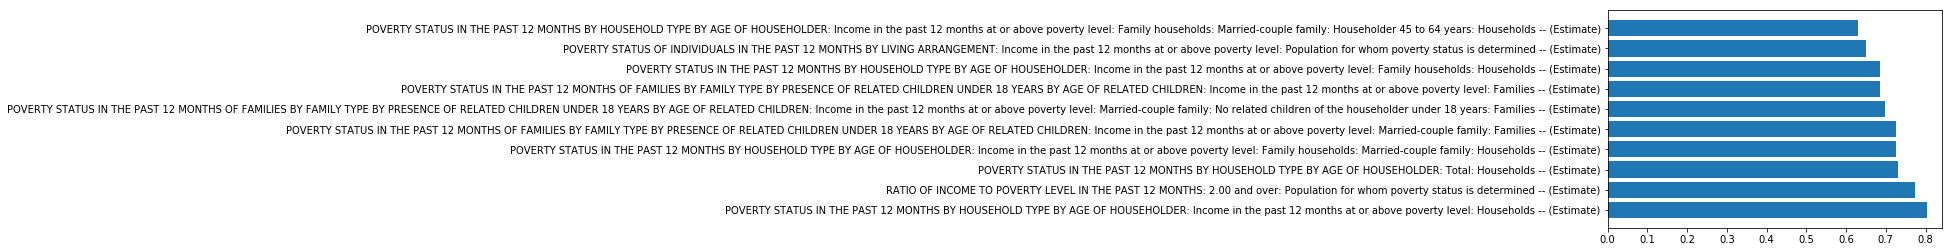

In [39]:
plt.barh(correlations_df.index[:10], correlations_df["correlation"].values[:10])
plt.show()

## Case Study: How gross income per capita affects educational attainment<a class="anchor" id="case-study"></a>

## Mapping the Data<a class="anchor" id="data-mapping"></a>

## Classification<a class="anchor" id="classification"></a>

## Summary<a class="anchor" id="summary"></a>